**Computational Tools for Data Science, Fall 2023, DTU**

# Week 8: Mining social network graphs

## Exercise 1: Divisive clustering via Girvan–Newman

Implement a divisive hierarchical clustering algorithm via the Girvan–Newman method and
compute modularity scores. 

Hence, you should implement the following parts:
1. Compute the betweenness centrality for every edge of a graph.
2. Implement a divisive hierarchical clustering algorithm based on removing edges with highest betweenness centrality and considering connected components as clusters.
3. Compute modularity for a clustering of a graph.

Test your implementations on the Karate-Club graph, found in `nx.karate_club_graph()`.

Compare your implementations with the ones from networkx :
- networkx.algorithms.centrality.edge betweenness centrality
- networkx.algorithms.community.girvan newman
- networkx.algorithms.community.modularity

Use `matplotlib` to visualise the communities.

In [149]:
import networkx as nx

In [272]:
# Using example from the slides of the lecture
G_example = nx.Graph()

all_nodes = ['A','B','C','D','E','F','G','H']
G_example.add_nodes_from(all_nodes)

all_edges = [
    ('E','D'),('E','F'),
    ('F','G'),('D','G'),('D','B'),('B','A'),('B','C'),('A','H'),
    ('D','F'),('A','C')
]
G_example.add_edges_from(all_edges)

G_example = G_example.to_undirected()

In [245]:
def step1(G, root):
    """
       Perform Breadth-First Search to get all shortest paths from the root in given graph G
       G: networkx graph
       root: node from G to consider as root
    """
    # List to keep track of visited nodes
    visited, queue = [], []
    # Initialize shortest paths
    shortest_paths_dict = {}
    
    visited.append(root)
    queue.append((root, [root]))

    while queue:
        s, path = queue.pop(0)

        for neighbour in list(G.neighbors(s)):
            if neighbour != root:
                new_path = path + [neighbour]
                if neighbour not in visited:
                    visited.append(neighbour)
                    queue.append((neighbour, new_path))
                    shortest_paths_dict[neighbour] = [new_path]
                else:
                    if len(new_path) == len(shortest_paths_dict[neighbour][0]):
                        shortest_paths_dict[neighbour].append(new_path)

    return shortest_paths_dict

In [246]:
def step2(G, shortest_paths_dict):
    l2 = {}
    for v in list(G.nodes()):
        if v in list(shortest_paths_dict.keys()):
            l2[v] = len(shortest_paths_dict[v])
        else:
            l2[v]=0
    return l2

In [247]:
def find_shortest_r2y_paths_using_e(all_paths, e):
    result = []
    start, end = e
    for aPath in all_paths:
        one_way = ''.join([str(a) for a in [start, end]]) in ''.join([str(a) for a in aPath])
        reverse_way = ''.join([str(a) for a in [end, start]]) in ''.join([str(a) for a in aPath])
        if one_way or reverse_way:
            result.append(aPath)
    return result

def step3(G, shortest_paths_dict, l2):
    b_r = []
    for start_node, end_node in list(G.edges()):
        list_to_sum = []
        for y in list(G.nodes()):
            if y in list(shortest_paths_dict.keys()):
                all_shortest_r2y_paths = shortest_paths_dict[y]
                all_shortest_r2y_using_e = find_shortest_r2y_paths_using_e(all_shortest_r2y_paths, [start_node, end_node])
                list_to_sum.append(len(all_shortest_r2y_using_e)/len(all_shortest_r2y_paths))
                # print((start_node, end_node), y, all_shortest_r2y_paths,all_shortest_r2y_using_e, list_to_sum)
        b_r.append([[start_node, end_node], sum(list_to_sum)])
    return b_r

In [248]:
# compute final betweeness
def edge_betweeness(G, e):
    start, end = e
    to_sum = []
    for r in list(G.nodes()):
        # step 1
        shortest_paths_dict = step1(G, r)
        # step 2
        l2 = step2(G, shortest_paths_dict)
        # step 3
        b_r = step3(G, shortest_paths_dict, l2)
        for edge_list, score in b_r:
            if (edge_list == [start, end]) or (edge_list == [end, start]):
                to_sum.append(score)
    return 0.5 * sum(to_sum)

In [249]:
def all_edge_betweeness(G):
    result = []
    for start, end in list(G.edges()):
        aScore = edge_betweeness(G, [start, end])
        result.append([
            [start, end],
            aScore
        ])
    return result

In [250]:
def bfs(graph):
    """SOURCE: https://www.educative.io/answers/how-to-implement-a-breadth-first-search-in-python"""
    result = {}
    for node in list(graph.nodes()):
        visited = [] # List to keep track of visited nodes.
        queue = []     #Initialize a queue
        visited.append(node)
        queue.append(node)

        while queue:
            s = queue.pop(0) 

            for neighbour in graph[s]:
                if neighbour not in visited:
                    visited.append(neighbour)
                    queue.append(neighbour)
        result[node] = set(visited)
    return result

def counting_clusters(bfs_result):
    distinct_sets = []
    for aSet in list(bfs_result.values()):
        if not aSet in distinct_sets:
            distinct_sets.append(aSet)
    return distinct_sets

In [273]:
def clustering(G_original):
    communities = {}
    nb_iterations = 0
    # create a copy of the G
    G = nx.Graph()
    G.add_nodes_from(G_original.nodes())
    G.add_edges_from(G_original.edges())
    G = G.to_undirected()
    while (len(list(G.edges()))) > 0:
        # compute betweeness centrality for all edges
        b_c_edges = all_edge_betweeness(G)
        b_c_edges.sort(key=lambda x:x[1], reverse=True)
        # remove the edge with highest centrality
        G.remove_edge(b_c_edges[0][0][0], b_c_edges[0][0][1])
        # check the nb of sub graphs in G
        clusters_result = bfs(G)
        distinct_sets = counting_clusters(clusters_result)
        # save sets
        communities[nb_iterations] = distinct_sets
        nb_iterations += 1
    return communities

In [274]:
communities = clustering(G_example)

In [275]:
communities

{0: [{'A', 'B', 'C', 'H'}, {'D', 'E', 'F', 'G'}],
 1: [{'A', 'B', 'C'}, {'D', 'E', 'F', 'G'}, {'H'}],
 2: [{'A', 'B', 'C'}, {'D', 'E', 'F', 'G'}, {'H'}],
 3: [{'A', 'B', 'C'}, {'D', 'F', 'G'}, {'E'}, {'H'}],
 4: [{'A', 'B', 'C'}, {'D', 'F', 'G'}, {'E'}, {'H'}],
 5: [{'A'}, {'B', 'C'}, {'D', 'F', 'G'}, {'E'}, {'H'}],
 6: [{'A'}, {'B'}, {'C'}, {'D', 'F', 'G'}, {'E'}, {'H'}],
 7: [{'A'}, {'B'}, {'C'}, {'D', 'F', 'G'}, {'E'}, {'H'}],
 8: [{'A'}, {'B'}, {'C'}, {'D'}, {'E'}, {'F', 'G'}, {'H'}],
 9: [{'A'}, {'B'}, {'C'}, {'D'}, {'E'}, {'F'}, {'G'}, {'H'}]}

In [301]:
def Avw_indicator_function(G, v, w):
    if (v,w) in list(G.edges()) or (w,v) in list(G.edges()):
        return 1
    return 0

def modularity(G, clusters_list):
    Q = 0
    m = len(list(G.edges()))
    for aCommunity in clusters_list:
        for v in list(aCommunity):
            for w in list(aCommunity):
                if v != w:
                    new_term = Avw_indicator_function(G, v, w) - (G.degree(v)*G.degree(w))/(2*m)
                    Q += new_term
    return Q/(2*m)

In [323]:
def compute_modularity_for_all_communities(G, all_communities):
    result = []
    for aCommunityRepartition in list(all_communities.values()):
        aModularity = modularity(G, aCommunityRepartition)
        result.append(
            [aCommunityRepartition, aModularity]
        )
    return result

In [329]:
all_clusters_with_modularity = compute_modularity_for_all_communities(G_example, communities)
all_clusters_with_modularity.sort(key= lambda x:x[1], reverse=True)
all_clusters_with_modularity
print('Best:', all_clusters_with_modularity[0])

Best: [[{'C', 'A', 'H', 'B'}, {'G', 'F', 'D', 'E'}], 0.5349999999999999]


In [331]:
best_communities = [list(s) for s in all_clusters_with_modularity[0][0]]
best_modularity = modularity(G_example, all_clusters_with_modularity[0][0])

print('best_communities:', best_communities)
print('- associated best_modularity:', best_modularity)

best_communities: [['C', 'A', 'H', 'B'], ['G', 'F', 'D', 'E']]
- associated best_modularity: 0.5349999999999999


In [332]:
# comparing with NetworkX

nx_communities = nx.algorithms.centrality.edge_betweenness_centrality(G_example)

nx_girvan_newman = nx.algorithms.community.centrality.girvan_newman(G_example)

nx_best_community = tuple(sorted(c) for c in next(nx_girvan_newman))
print('Comparing best communities:')
print('\t- My code:', best_communities)
print('\t- NetworkX:', nx_best_community)

nx_modularity = nx.algorithms.community.quality.modularity(G_example, nx_best_community)
print('\nComparing Modularity:')
print('\t- My code:', best_modularity)
print('\t- NetworkX:', nx_modularity)

Comparing best communities:
	- My code: [['C', 'A', 'H', 'B'], ['G', 'F', 'D', 'E']]
	- NetworkX: (['A', 'B', 'C', 'H'], ['D', 'E', 'F', 'G'])

Comparing Modularity:
	- My code: 0.5349999999999999
	- NetworkX: 0.395


## Exercise 2

Compute the eigenvalues of the Laplacian matrix L(G) of G.

(To compute eigenvalues you could use numpy.linalg.eigvals (you should import numpy).)
(If you use networkx, you could use networkx.linalg.laplacianmatrix to obtain the Laplacian
matrix of G.)

Derive a bipartition of G via the second smallest eigenvalue of L(G).

Compare your result with SpectralClustering from sklearn.cluster for 2 clusters. Experiment
with SpectralClustering, e.g. by using more clusters or running it on the Karate-club graph
from networkx.karate club graph.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy
import sklearn

%load_ext watermark
%watermark --iversions

matplotlib: 3.5.2
networkx  : 2.8.4
numpy     : 1.21.5
sklearn   : 1.0.2
scipy     : 1.9.1



**Consider the following graph G.**

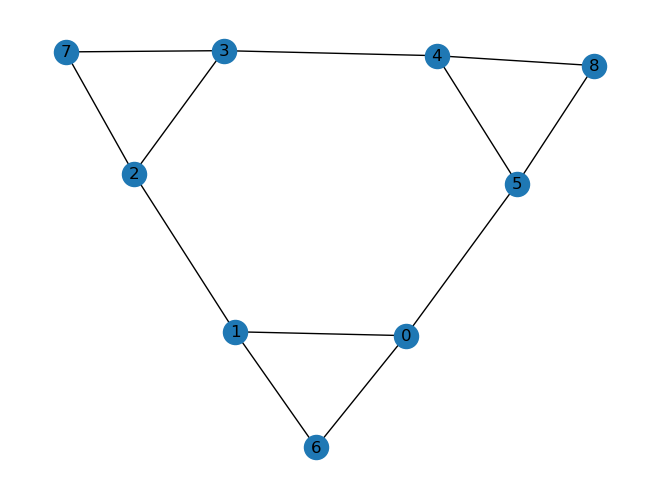

In [2]:
G = nx.cycle_graph(6)
G.add_edges_from([(0,6), (6,1), (2,7), (7,3), (4,8), (8,5)])
nx.draw(G,with_labels=True)

**Compute the eigenvalues of the Laplacian matrix L(G) of G.**

In [3]:
# make sure to update scipy to >1.8
# https://github.com/pyg-team/pytorch_geometric/issues/4378
laplacian = nx.linalg.laplacian_matrix(G).todense()
laplacian

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


matrix([[ 3, -1,  0,  0,  0, -1, -1,  0,  0],
        [-1,  3, -1,  0,  0,  0, -1,  0,  0],
        [ 0, -1,  3, -1,  0,  0,  0, -1,  0],
        [ 0,  0, -1,  3, -1,  0,  0, -1,  0],
        [ 0,  0,  0, -1,  3, -1,  0,  0, -1],
        [-1,  0,  0,  0, -1,  3,  0,  0, -1],
        [-1, -1,  0,  0,  0,  0,  2,  0,  0],
        [ 0,  0, -1, -1,  0,  0,  0,  2,  0],
        [ 0,  0,  0,  0, -1, -1,  0,  0,  2]])

In [4]:
# compute the eigenvalues and eigenvectors
evals, evecs = np.linalg.eig(laplacian)

**Derive a bipartition of G via the second smallest eigenvalue of L(G).**

In [5]:
# second smallest eigenvalue, also called the fiedler index
fiedler_index = sorted(evals)[1]

# crude way of finding the corresponding eigenvector
i = 0
for eigenval in evals:
    if eigenval == fiedler_index:
        idx = i
    i += 1

evec = evecs[:, idx].tolist()
evec

[[-0.02479811632008378],
 [-0.2461046225049272],
 [-0.3339828703304553],
 [-0.1508382442635029],
 [0.35878098665053887],
 [0.3969428667684303],
 [-0.20794274238703603],
 [-0.37214475044834616],
 [0.5800874928353824]]

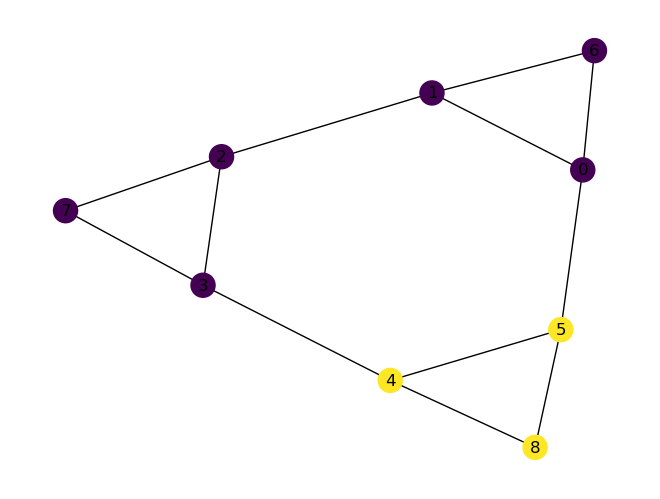

In [6]:
# negative eigenvector values correspond to one cluster and positive to another
clusters = []
for e in evec:
    if e[0] < 0:
        clusters.append(0)
    else:
        clusters.append(1)

nx.draw(G, with_labels=True, node_color=clusters)

**Compare your result with SpectralClustering from sklearn.cluster for 2 clusters.**

/opt/miniconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


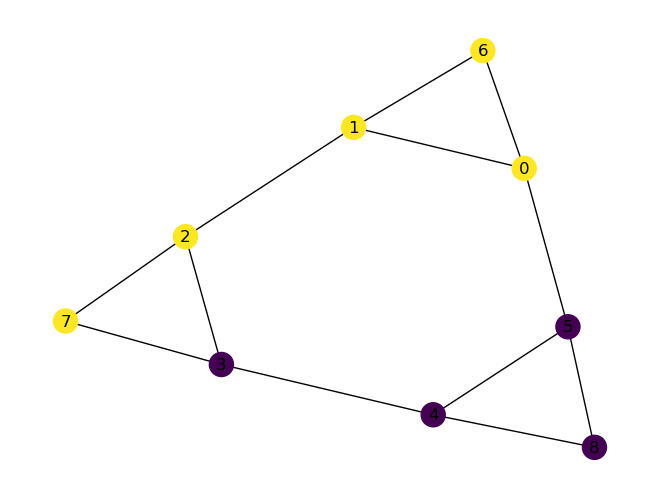

In [7]:
from sklearn.cluster import SpectralClustering

adj_matrix = nx.to_numpy_matrix(G) 
node_list = list(G.nodes())

#non-deterministic btw
clusters = SpectralClustering(affinity='precomputed', n_clusters=2).fit_predict(adj_matrix)

nx.draw(G, with_labels=True, node_color=clusters)

**Experiment
with SpectralClustering, e.g. by using more clusters or running it on the Karate-club graph
from networkx.karate club graph.**

/opt/miniconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


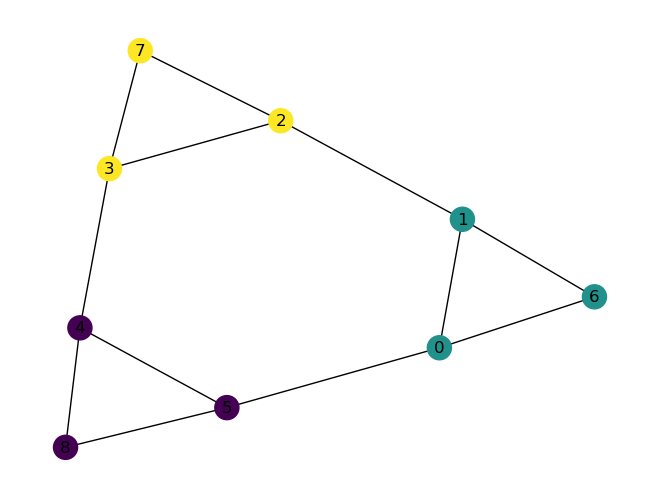

In [8]:
clusters = SpectralClustering(affinity='precomputed', n_clusters=3).fit_predict(adj_matrix)

nx.draw(G, with_labels=True, node_color=clusters)

/opt/miniconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


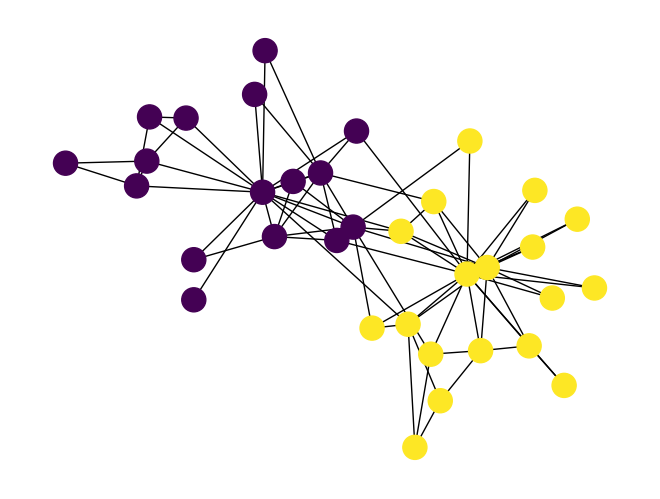

In [9]:
K = nx.karate_club_graph()

adj_matrix = nx.to_numpy_matrix(K) 
node_list = list(K.nodes())

clusters = SpectralClustering(affinity='precomputed', n_clusters=2).fit_predict(adj_matrix)

nx.draw(K, node_color=clusters)

### Helpful resources

- https://en.wikipedia.org/wiki/Laplacian_matrix
- https://math.stackexchange.com/questions/1407811/why-is-second-smallest-eigenvalue-and-the-corresponding-eigenvector-used-to-part
- https://towardsdatascience.com/graph-laplacian-and-its-application-in-machine-learning-7d9aab021d16